**CLUSTERING DE DOCUMENTOS**



Este programa permite realizar clustering (agrupación) del tipo K-Means de documentos a partir de un corpus. Los documentos se representan según los modelos vectoriales estándares.

Primero, necesitamos instalar algunos paquetes:

In [ ]:
#!pip install spacy
# !python -m spacy download es_core_news_sm

Debemos importar algunas bibliotecas y utilitarios:

In [1]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS
import es_core_news_sm
import os
from spacy.lang.es.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import regex
from string import punctuation
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Re-utilizamos nuestra función **CrearVSM(textos,nombreModelo)** que permite crear un modelo vectorial 
simple del tipo TFxIDF y grabarlo para posterior uso:

In [2]:
def CrearVSM(textos,nombreModelo):
  modelo  = TfidfVectorizer(use_idf=True, norm=None, binary=False)
  matriz_features  = modelo.fit_transform(textos)
  vocabulario      = modelo.vocabulary_
  dtm              = matriz_features.toarray()
  GrabarModelo(nombreModelo,dtm,vocabulario)
  
def GrabarModelo(NombreModelo,vectores,vocab):
   existe = os.path.isdir(NombreModelo)
   if not existe:
       os.mkdir(NombreModelo)
   joblib.dump(vectores, NombreModelo +"/"+'tfidf.pkl') 
   joblib.dump(vocab, NombreModelo +"/"+'vocab.pkl') 
  
def CargarModelo(NombreModelo):
    vectores = joblib.load(NombreModelo+"/"+'tfidf.pkl')
    vocab  = joblib.load(NombreModelo+"/"+'vocab.pkl')
    return(vectores,vocab)

Ahora, re-usamos algunas funciones utilitarias definidas previamente:

In [3]:
def CrearCorpus(path):
  directorio = os.listdir(path)
  corpus = []
  doc_id = []  
  for filename  in directorio:
     texto = open(path+filename,'r',encoding="latin-1").read()
     texto = ConvertirAcentos(texto)
     corpus.append(texto)
     doc_id.append(filename)
  return(corpus,doc_id)

def ConvertirAcentos(texto):
    texto=texto.replace("\xc3\xa1","á")
    texto=texto.replace("\xc3\xa9","é")   
    texto=texto.replace("\xc3\xad","í")
    texto=texto.replace("\xc3\xb3","ó")
    texto=texto.replace("\xc3\xba","ú")
    texto=texto.replace("\xc3\x81","Á")
    texto=texto.replace("\xc3\x89","É")
    texto=texto.replace("\xc3\x8d","Í")
    texto=texto.replace("\xc3\x93","Ó")
    texto=texto.replace("\xc3\x9a","Ú")
    texto=texto.replace("\xc3±","ñ")
    return(texto)

def PreProcesar(textos):
    texto_limpio = []
    for texto in textos:  
        texto = EliminarStopwords(texto.lower())    
        texto = Lematizar(texto)     
        texto = EliminaNumeroYPuntuacion(texto)      
        if len(texto)!=0:
          texto = regex.sub(' +', ' ', texto)
          texto_limpio.append(texto)
    return(texto_limpio)

def EliminaNumeroYPuntuacion(oracion):
    string_numeros = regex.sub(r'[\”\“\¿\°\d+]','', oracion)
    return ''.join(c for c in string_numeros if c not in punctuation)

def Lematizar(oracion):
   doc = nlp(oracion)
   lemas = [token.lemma_ for token in doc]
   return(" ".join(lemas))  
  
def EliminarStopwords(oracion):
    Tokens = Tokenizar(oracion)
    oracion_filtrada = [word for word in Tokens if word not in STOP_WORDS]
    return(" ".join(oracion_filtrada))

def Tokenizar(oracion):
    doc = nlp(oracion)
    tokens = [palabra.text for palabra in doc]
    return(tokens)

Ahora definimos la función **clustering(MatrizDocumentos,K)**, que realiza clustering K-Means a partir de una **Matriz de Documentos** generada  con el modelo TFxIDF y un número **K** de clusters y retorna los clusters creados. Esta corresponde una lista donde indica el número (ID) de cluster para cada documento:

In [4]:
def clustering(MatrizDocumentos,K):
  modelo = KMeans(n_clusters=K)   
  modelo.fit(MatrizDocumentos)        
  return(modelo)

Luego, definimos la función **VisualizarClusters(clusters,docIDs,MatrizDocumentos)**, que toma los clusters generados previamente, los identificadores de documentos y la matriz de documentos, y visualiza los clusters en un mapa 2-dimensional. Con fines de visualización, se asignan diferentes colores a los clusters ccon un máximo de 5 clusters.

Con el fin de gráficar los datos en 2 dimensiones, se aplica  escalamiento  multidimensional ([MDS](https://www.statisticshowto.com/multidimensional-scaling/)). Este toma distancia entre todos los pares de vectores de documentos, calcula la nueva escala de distancia  entre puntos, y luego toma las 2 primeras componentes:

In [5]:
def VisualizarClusters(clusters,docIDs,MatrizDocumentos):
    (x_nueva,y_nueva) = Escalar(MatrizDocumentos)
    color_cluster = {0: '#1b9e77', 1: '#d95f02', 
                      2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
    nombre_cluster = {0: 'Cluster0', 
                      1: 'Cluster1', 
                      2: 'Cluster2', 
                      3: 'Cluster3', 
                      4: 'Cluster4'}
    df = pd.DataFrame(dict(x=x_nueva,y=y_nueva,label=clusters,title=docIDs)) 
    grupos = df.groupby('label')
    fig, ax = plt.subplots(figsize=(17, 9)) 
    for nombre, grupo in grupos:
        ax.plot(grupo.x, grupo.y, marker='o', linestyle='', 
               label=nombre_cluster[nombre], color=color_cluster[nombre]) 
    ax.legend() 
    for i in range(len(df)):
        ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  
    plt.show() 

def Escalar(data_matrix):
    dist = 1 - cosine_similarity(data_matrix)
    mds = MDS(n_components=2, dissimilarity="precomputed")
    pos = mds.fit_transform(dist)  
    x, y = pos[:, 0], pos[:, 1]
    return(x,y)

Un aspecto importante en clustering K-Means de documentos es fijar el número adecuado de clusters a generar (*K*). Una forma de determinar el mejor *K*, es graficar el error de clustering (i.e., **Suma de distancias cuadradas o SSE**)  en función de cada valor de *K* posible que toma como máximo el número de documentos. Luego, aplicamos la "*regla del codo*" para determinar cuando se observa una baja en el SSE para quedarnos con su valor de *K* correspondiente.

Para visualizar esto, utilizamos la función **MostrarError(MatrizDocumentos,MaxDoc)**, que muestra los  valores de error (SSE) de K-Means para diferentes valores de *K*: 

In [6]:
def MostrarError(MatrizDocumentos,MaxDoc):
    score = []  
    valores_k = list(range(2, MaxDoc))  
    for k in valores_k:
       Clusters = clustering(MatrizDocumentos,K)
       sse = Clusters.inertia_
       score.append(sse)   
    plt.figure(figsize=(6, 6))
    plt.plot(valores_k, score, '-o')
    plt.xlabel(r'Número de clusters (K)')
    plt.ylabel("Suma de distancias cuadradas (SSE)")

Ejecutamos  nuestro programa principal, ajustando la ubicación del orpus e inicializando métodos:

In [18]:
PATH = 'C:\\Users\\Usuario\\Big Data\\Text Mining\\CORPUS\\CORPUS\\coronavirus\\'
nlp = es_core_news_sm.load()

Ahora, creamos y preprocesamos nuestro corpus, y generamos nuestro modelo vectorial para los documentos (TFxIDF): 

In [19]:
(corpus,docID) = CrearCorpus(PATH)
textos  = PreProcesar(corpus)
CrearVSM(textos,"mi_tfidf")

Cargamos nuestro modelo vectorial de documentos, realizamos nuestra tarea de clustering, y visualizamos los clusters generados. Los identificadores de clusters se encuentran en la lista **modelo.labels_**.

Por ahora, asumimos que sólo deseamos generar *K=4* clusters (numerados de 0 a 3).

C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


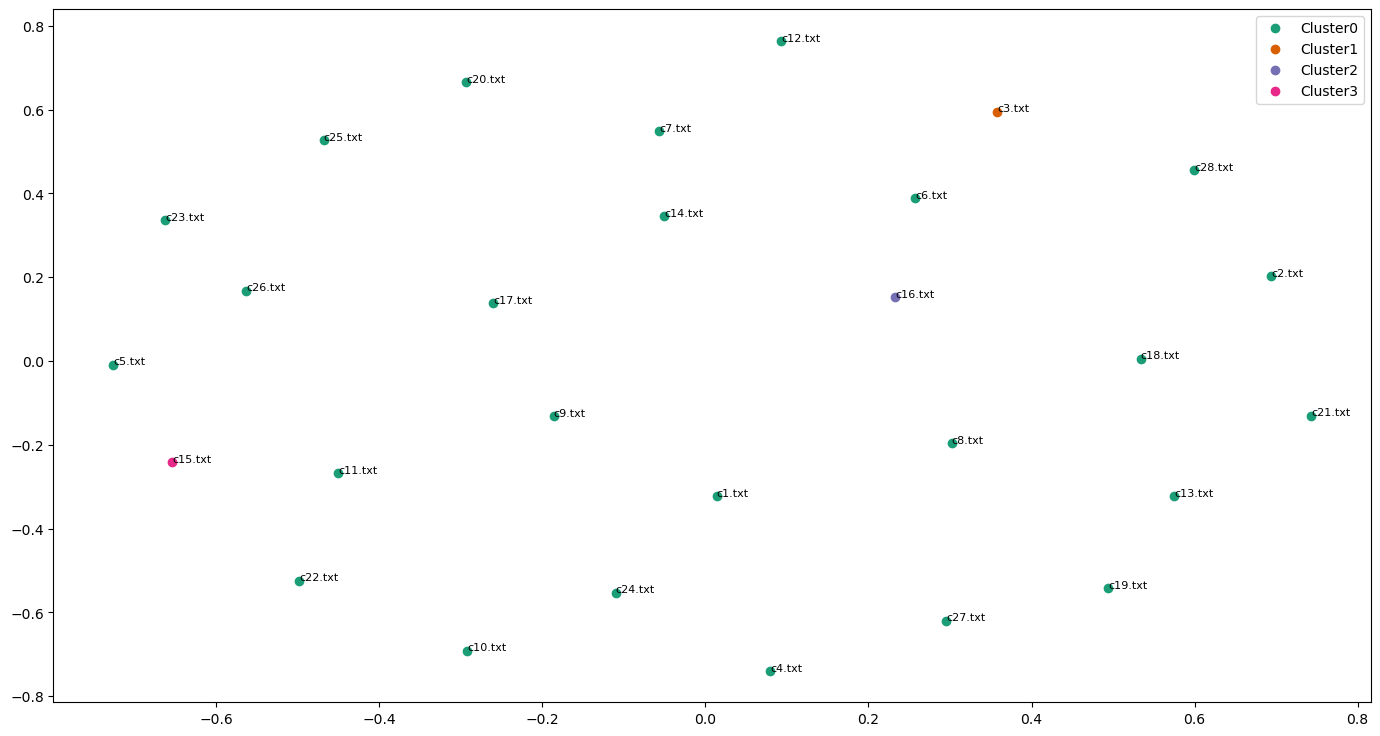

In [20]:
(vectores, vocabulario) = CargarModelo("mi_tfidf")
K = 4    
modelo = clustering(vectores,K)
VisualizarClusters(modelo.labels_,docID,vectores)

Opcionalmente, si queremos estar seguro de cuál debería ser el número óptimo de clusters (*K*), podemos mostrar el gráfico de SSE:

In [21]:
print(modelo.labels_)

[0 0 0 0 0 0 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when t

C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when t

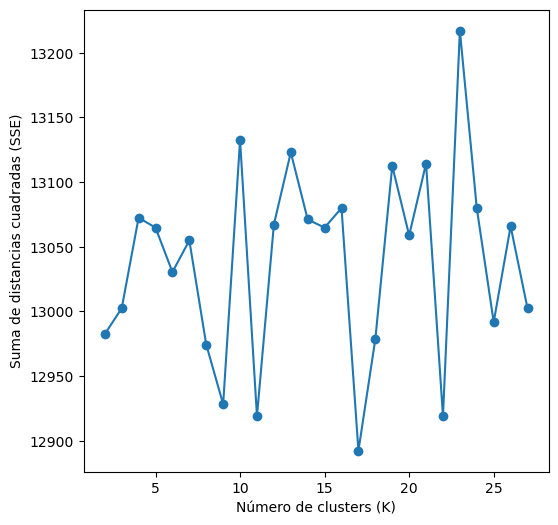

In [22]:
MaxDoc = len(docID)
MostrarError(vectores,MaxDoc)